In [1]:
import cv2
import numpy as np
from pylab import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 15,8
import matplotlib.pyplot as plt
import io
import base64
from IPython.display import HTML
from IPython.display import display

## Objective: Detect taps on the Phone Camera

The objective of this EDA is to see if we can detect taps on a phone camera and compare a signal processing technique to that of a deep learning or pure statistical analysis technique. 

#### Signal processing
For signal processing we are only interested in the brightness of the image as it changes and treat it as a wave form and we are trying to determine the values for which the wave form matches a tap

#### Statistical Approach
For a statistical approach we are interested in the histogram as it changes over time and train using a linear classifier and a neural network for comparison

#### Deep Learning Approach
We extract features directly from the image to train and detect whether there is a tap



In [2]:
def play_video(file):
    video = io.open(file, 'r+b').read()
    encoded = base64.b64encode(video)
    display(HTML(data='''<video style="height:500px" alt="test" controls>
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
#play_video('video.mp4')

In [3]:
def normalize(arr):
    """
        Returns copy of array min-max normalized
    """
    arr=arr.copy()
    return (arr-arr.min())/(arr.max()-arr.min())
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized
def read_video(file):
    """
        Returns a tuple of and with the following order:
            the frames as an np.array
            the brightness (sum of all pixels)  
            the histogram (sum of all pixels along a channel (e.g. rgb)
            
        Potential improvements include doing this in parallel and some of the processing of the images 
        like histogram or sum in the GPU like Numba for faster processing
    """
    cap=cv2.VideoCapture(file)
    flag,frame=cap.read()
    
    # Array for frames (input size, w,h,channels)
    frame_queue=[]
    # brightness (input size, 1)
    brightness_arr=[]
    # histogram (input size, 256)
    histogram_arr=[]
    
    def get_hist(frame):
        return cv2.calcHist(frame,[0],None,[256],[0,256])
    
    # while there is input
    while flag:
        # conver frame from default BGR to RGB
        frame_queue.append(image_resize(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB),height=400))
        # Brightness array
        brightness_arr.append(frame.sum())
        # Brightness array
        
        histogram_arr.append(get_hist(frame))
        flag,frame=cap.read()
        

    brightness_arr=np.array(brightness_arr)
    brightness_arr=normalize(brightness_arr)
    histogram_arr=np.array(histogram_arr)
    histogram_arr=normalize(histogram_arr)
    frame_queue=np.array(frame_queue)
    return (frame_queue,brightness_arr,histogram_arr)


In [4]:

(frame_queue,brightness_arr,histogram_arr)=read_video("video.mp4")

## Visualizing Random Frames

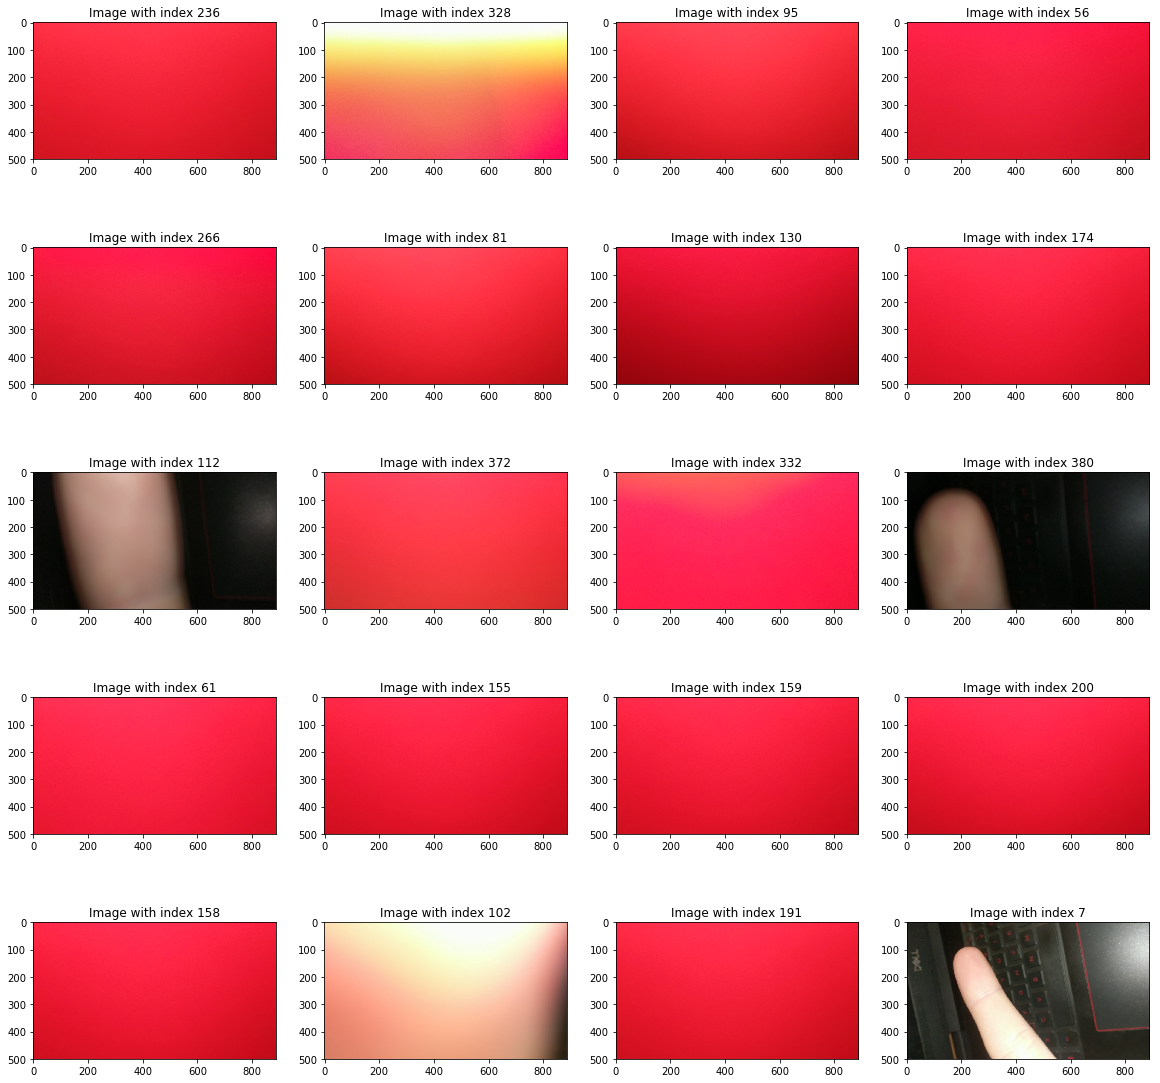

In [5]:
def visualize_random_frame(frame_queue):
    """
        Plots random frames from the frame queue
    """

    import random
    w=10

    h=10
    fig=plt.figure(figsize=(20, 20))
    columns = 4
    rows = 5
    for i in range(1, columns*rows +1):
        random_index=np.random.choice(frame_queue.shape[0])

        img = frame_queue[random_index]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
        plt.title("Image with index %s"%random_index)

    plt.show()
visualize_random_frame(frame_queue)

## Plotting the Brightness Array over time

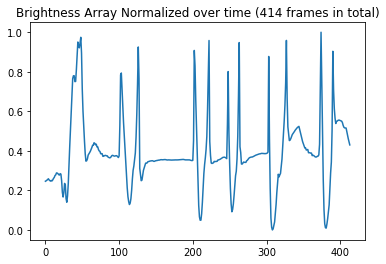

In [6]:
plt.plot(brightness_arr)
plt.title("Brightness Array Normalized over time (%s frames in total)"%brightness_arr.shape[0])
plt.show()

## Plotting the Histgram Values Array of a single frame

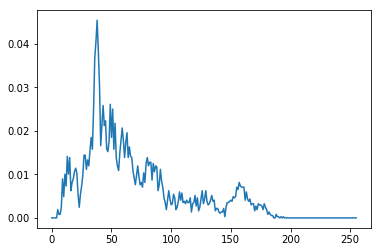

In [7]:
plt.plot(histogram_arr[0])

## Signal Processing Approach

Identify the threshold for which the camera is tapped

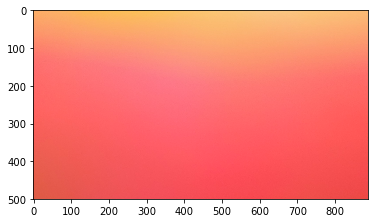

In [8]:
plt.imshow(frame_queue[np.argmin(brightness_arr[(brightness_arr>0.35) & (brightness_arr<0.45)])])
plt.show()

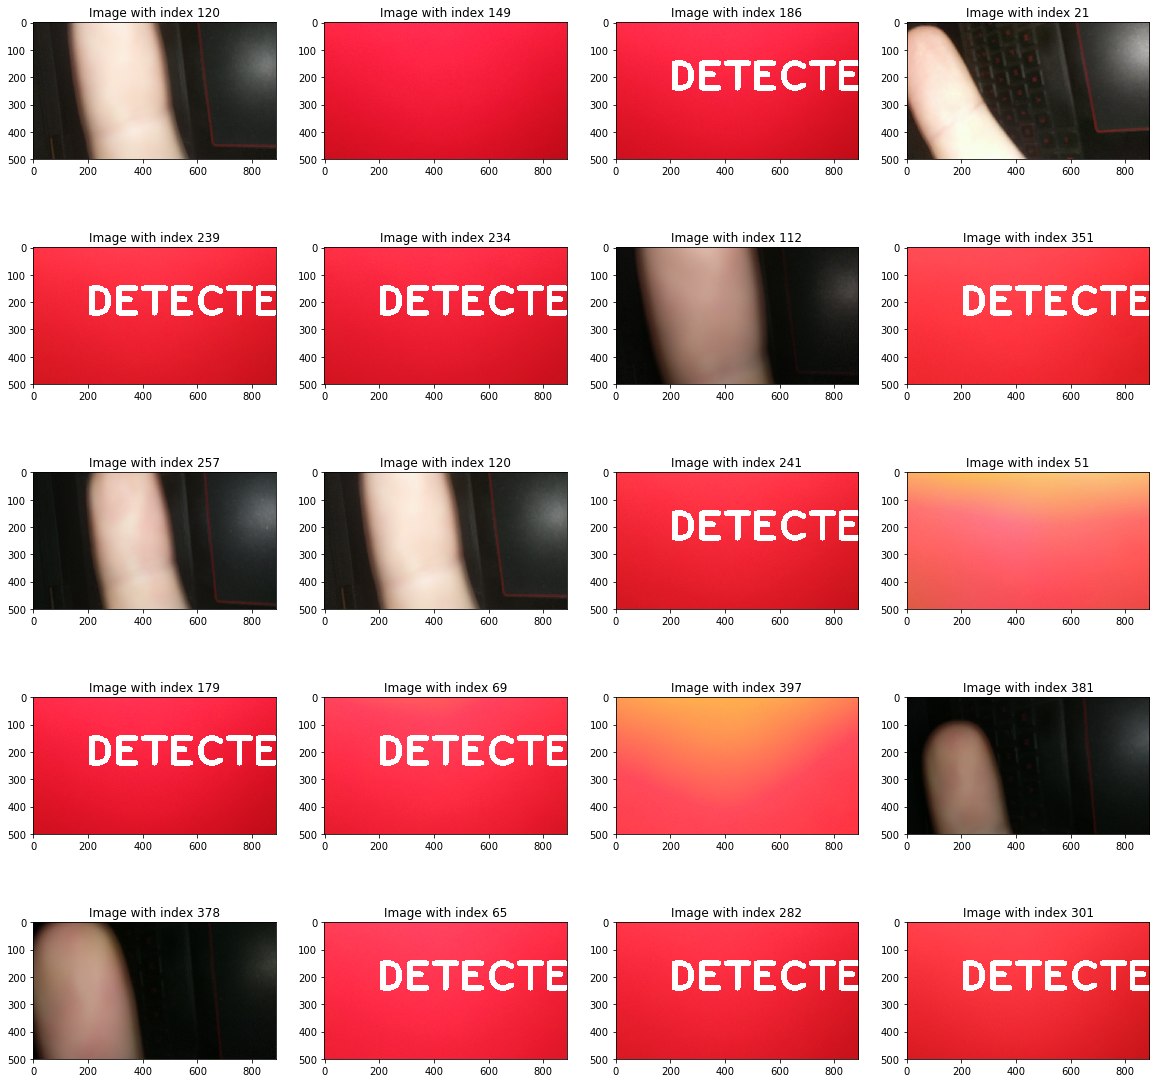

In [9]:
import time
def visualize_prediction(frame_queue,y):
    
    import random
    w=15

    h=15
    fig=plt.figure(figsize=(20, 20))
    columns = 4
    rows = 5
    for i in range(1, columns*rows +1):
        random_index=np.random.choice(frame_queue.shape[0])
        _frame=frame_queue[random_index]
        if y[random_index]:
            _frame=frame_add_text(_frame)
        fig.add_subplot(rows, columns, i)
        plt.imshow(_frame)
        plt.title("Image with index %s"%random_index)

    plt.show()
    
    
    out = cv2.VideoWriter('signal_processing.avi',cv2.VideoWriter_fourcc(*'MJPG'), 30, (frame_queue[0].shape[0],frame_queue[0].shape[1]))
    for idx,frame in enumerate(frame_queue):
        out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
        
        if y[idx]:
            _frame=frame_add_text(frame)
        cv2.imshow('frame',cv2.cvtColor(_frame, cv2.COLOR_RGB2BGR))
        time.sleep(0.01)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()
    out.release()
def frame_add_text(frame):
    return (cv2.putText(frame,'DETECTED',((frame.shape[1]-500)//2,(frame.shape[0])//2), cv2.FONT_HERSHEY_PLAIN, 10,(255,255,255),20))

visualize_prediction(frame_queue,(brightness_arr>0.35) & (brightness_arr<0.45))    

## Machine Learning Approach

Let's label our dataset using the above approach into 0 and 1, 0 being the class of not being blocked and 1 being the class of being blocked

**Task** Classify a frame based on the histogram of that frame into being blocked or not

In [10]:
(blocked_frame_queue,blocked_brightness_arr,blocked_histogram_arr)=read_video("blocked_video.mp4")

In [11]:
(clear_frame_queue,clear_brightness_arr,clear_histogram_arr)=read_video("clear_video.mp4")

In [12]:
y=np.concatenate([np.ones(blocked_frame_queue.shape[0]),np.zeros(clear_frame_queue.shape[0])])
x=np.concatenate([blocked_histogram_arr.reshape(blocked_histogram_arr.shape[:-1]),clear_histogram_arr.reshape(clear_histogram_arr.shape[:-1])])

In [13]:
#from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y)
clf = GaussianProcessClassifier(1.0 * RBF(1.0))
clf.fit(x_train, y_train)
clf.score(x_test,y_test)

# Not that bad 

0.9812834224598931

In [14]:
(frame_queue_test,_,histogram_arr_test)=read_video("test_video.mp4")
#play_video('test_video.mp4')

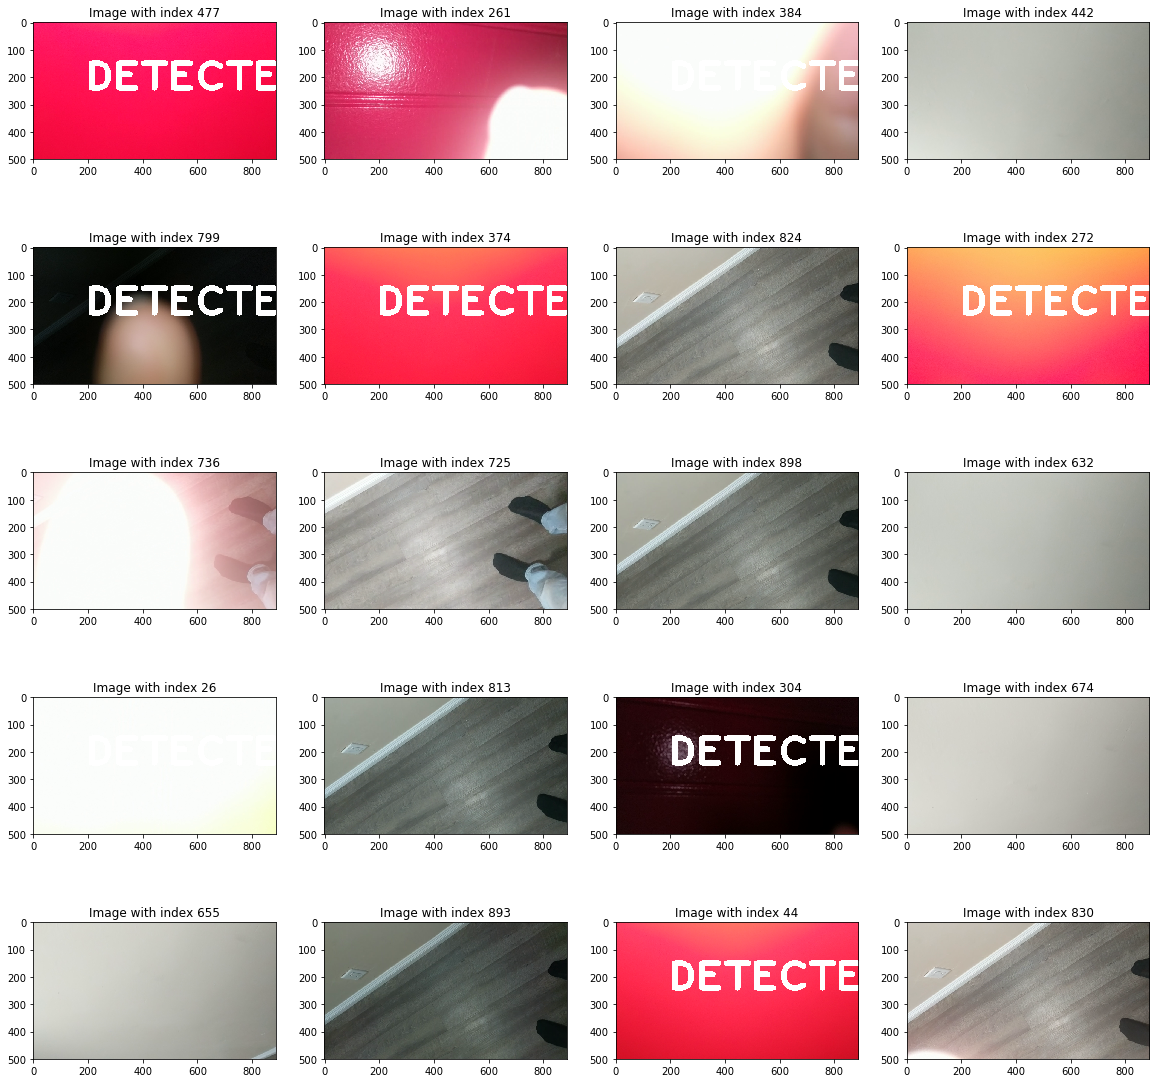

In [15]:
y_pred=clf.predict(histogram_arr_test.reshape(histogram_arr_test.shape[:-1]))
x_pred=frame_queue_test
visualize_prediction(x_pred,y_pred)
# Definetely not good but given we have a very small and badly labelled datasample it works impressively well

## Deep Learning Approach

Can we use convolutions to better detect the frames for which the image is blocked?
The idea is that the features extracted will work for activations that are solid colors instead of extracting detailed features, this might be an overkill approach for this problem but is interesting nevertheless

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten,MaxPooling2D

Using TensorFlow backend.


#### Fully-Connected on Histogram Data

In [17]:
my_model=Sequential()
my_model.add(Dense(x_train.shape[1]//2,activation="relu",input_shape=(x_train.shape[1],)))
my_model.add(Dense(x_train.shape[1]//4,activation="relu"))
my_model.add(Dense(x_train.shape[1]//8,activation="relu"))
my_model.add(Dense(1,activation="sigmoid"))
my_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 43,265
Trainable params: 43,265
Non-trainable params: 0
_________________________________________________________________


In [21]:
my_model.compile(loss="binary_crossentropy", optimizer="adam")
my_model.load_weights("detector_fc.h5")
loss=my_model.fit(x_train,y_train,epochs=100)
my_model.save_weights("detector_fc.h5")

Epoch 1/100
1121/1121 [==============================] - 0s 311us/step - loss: 1.2654e-05
Epoch 2/100
1121/1121 [==============================] - 0s 84us/step - loss: 1.9956e-05
Epoch 3/100
1121/1121 [==============================] - 0s 84us/step - loss: 5.8423e-04
Epoch 4/100
1121/1121 [==============================] - 0s 85us/step - loss: 2.2125e-05
Epoch 5/100
1121/1121 [==============================] - 0s 87us/step - loss: 1.0645e-05
Epoch 6/100
1121/1121 [==============================] - 0s 85us/step - loss: 3.9523e-06
Epoch 7/100
1121/1121 [==============================] - 0s 82us/step - loss: 3.1270e-06
Epoch 8/100
1121/1121 [==============================] - 0s 77us/step - loss: 2.8207e-06
Epoch 9/100
1121/1121 [==============================] - 0s 80us/step - loss: 2.6100e-06
Epoch 10/100
1121/1121 [==============================] - 0s 80us/step - loss: 2.4057e-06
Epoch 11/100
1121/1121 [==============================] - 0s 83us/step - loss: 2.2230e-06
Epoch 12/100
1121/

1121/1121 [==============================] - 0s 77us/step - loss: 2.8795e-07
Epoch 93/100
1121/1121 [==============================] - 0s 76us/step - loss: 2.8421e-07
Epoch 94/100
1121/1121 [==============================] - 0s 74us/step - loss: 2.8158e-07
Epoch 95/100
1121/1121 [==============================] - 0s 76us/step - loss: 2.7784e-07
Epoch 96/100
1121/1121 [==============================] - 0s 78us/step - loss: 2.7384e-07
Epoch 97/100
1121/1121 [==============================] - 0s 77us/step - loss: 2.7006e-07
Epoch 98/100
1121/1121 [==============================] - 0s 75us/step - loss: 2.6702e-07
Epoch 99/100
1121/1121 [==============================] - 0s 78us/step - loss: 2.6388e-07
Epoch 100/100
1121/1121 [==============================] - 0s 79us/step - loss: 2.6088e-07


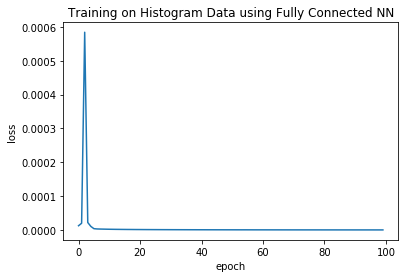

In [22]:
plt.plot(loss.history["loss"])
plt.title("Training on Histogram Data using Fully Connected NN")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

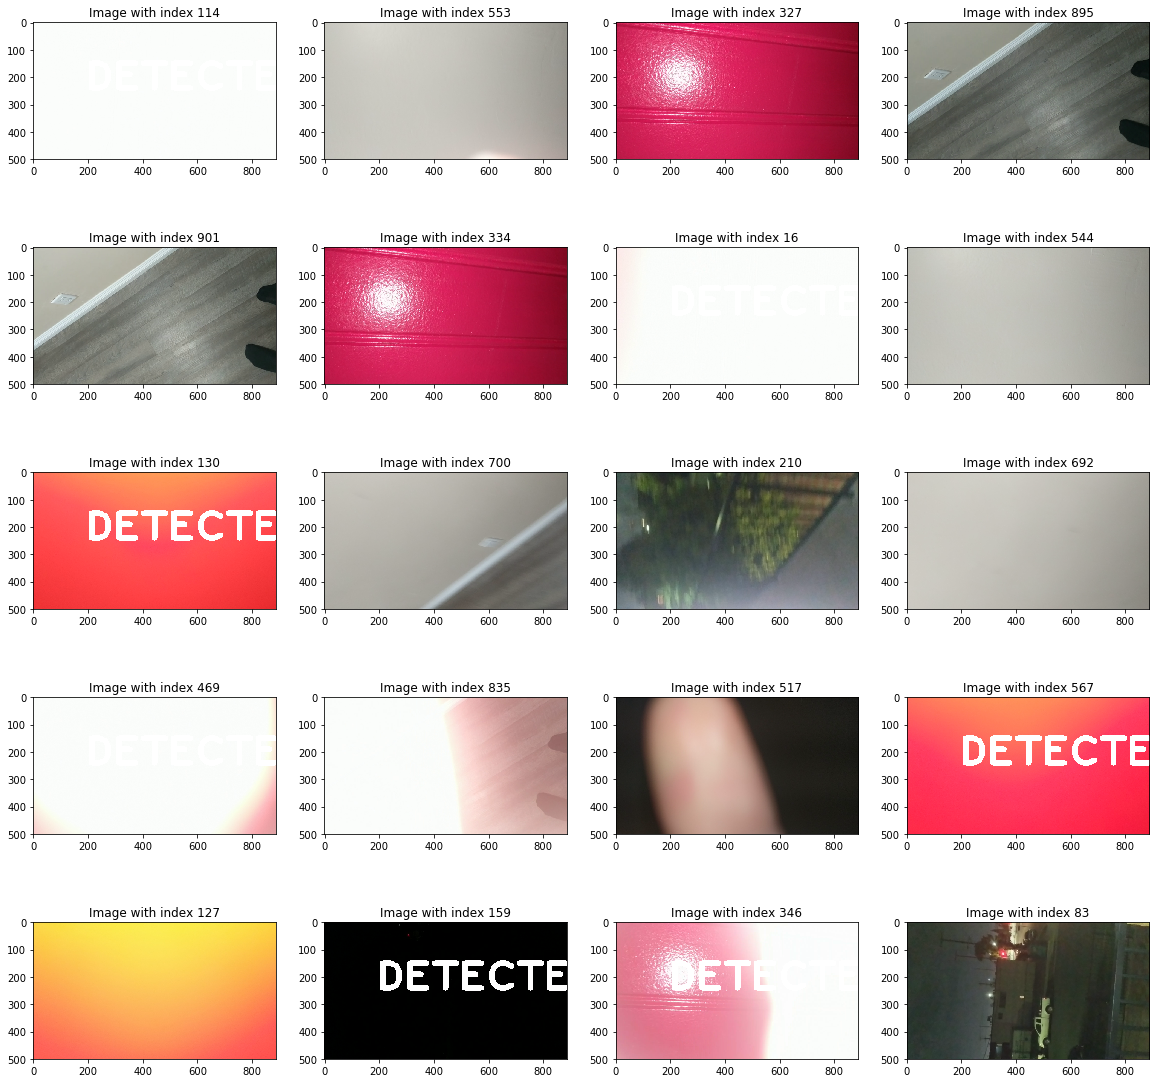

In [23]:
y_pred=clf.predict(histogram_arr_test.reshape(histogram_arr_test.shape[:-1]))
x_pred=frame_queue_test
visualize_prediction(x_pred,y_pred)

### Conv2D on Image Data

In [24]:
x_images=np.concatenate([blocked_frame_queue,clear_frame_queue])
x_train,x_test,y_train,y_test=train_test_split(x_images,y)


In [25]:
my_model=Sequential()

my_model.add(Conv2D(32,(3,3),activation="relu",input_shape=x_train.shape[1:]))
my_model.add(MaxPooling2D())

filters=32
for i in range(4):
    my_model.add(Conv2D(filters,(3,3),activation="relu"))
    my_model.add(MaxPooling2D())
    filters-=filters//4

my_model.add(Flatten())
my_model.add(Dense(x_train.shape[1]//2,activation="relu"))
my_model.add(Dense(x_train.shape[1]//4,activation="relu"))
my_model.add(Dense(x_train.shape[1]//6,activation="relu"))
my_model.add(Dense(x_train.shape[1]//8,activation="relu"))
my_model.add(Dense(1,activation="sigmoid"))
my_model.compile(loss="binary_crossentropy", optimizer="adam")
my_model.summary()
my_model.load_weights("detector_conv_32.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 498, 886, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 249, 443, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 247, 441, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 123, 220, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 121, 218, 24)      6936      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 60, 109, 24)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 58, 107, 18)       3906      
__________

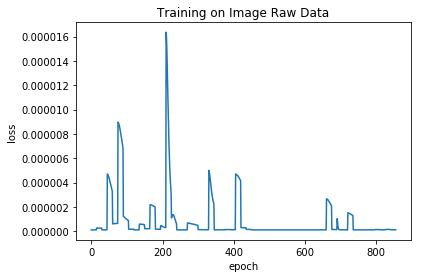

In [45]:
def batch(iterable, n=1):
    ""
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]
loss=[]
batch_num=0
for idx in batch(range(0, len(x_train)), 20):
    history=my_model.fit(x_train[idx],y_train[idx],epochs=15, verbose=False)
    loss+=history.history["loss"]
    batch_num+=1
plt.plot(loss)
plt.title("Training on Image Raw Data")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [46]:
my_model.save_weights("detector_conv_32.h5")

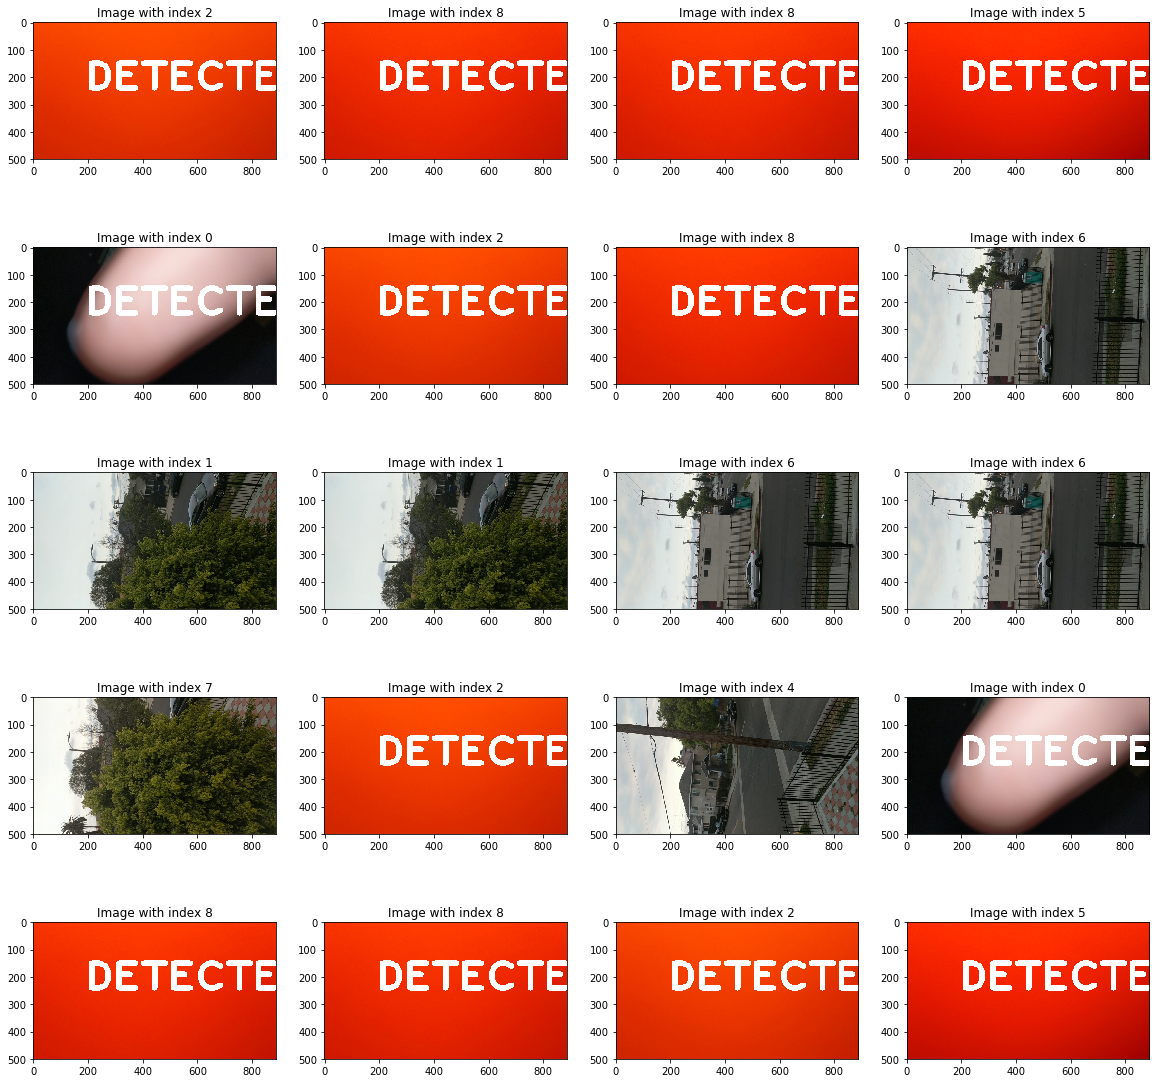

In [26]:
y_pred=my_model.predict(frame_queue_test[:10])
x_pred=x_test[:10]
visualize_prediction(x_pred,y_pred)